<a href="https://colab.research.google.com/github/BitWeavre/Unsupervised-Learning-Project/blob/main/Identify_Customer_Segments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [ ]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing as p
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [ ]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_table('AZDIAS_Feature_Summary.csv',sep=';')

In [ ]:
# Check the structure of the data after it's loaded (e.g. print the number of rows and columns, print the first few rows).

# We check out the general structure, description, and information about the data in the next few cells.

azdias.head(20)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [ ]:
azdias.tail(20)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891201,-1,3,1,3.0,4,2,3,2,2,3,...,1.0,4.0,3.0,1.0,3.0,4.0,3.0,3.0,7.0,5.0
891202,-1,2,2,5.0,1,4,1,2,5,4,...,1.0,4.0,3.0,2.0,5.0,4.0,2.0,4.0,8.0,5.0
891203,-1,4,2,1.0,4,1,5,1,3,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,4.0,8.0,5.0
891204,-1,3,1,5.0,4,3,4,4,2,1,...,2.0,3.0,1.0,0.0,1.0,3.0,4.0,4.0,7.0,3.0
891205,1,4,1,2.0,4,2,4,3,3,4,...,1.0,4.0,3.0,1.0,3.0,3.0,2.0,3.0,7.0,5.0
891206,-1,1,2,4.0,3,4,2,4,4,2,...,3.0,2.0,1.0,0.0,1.0,4.0,5.0,3.0,4.0,3.0
891207,1,3,2,1.0,5,1,5,1,2,4,...,2.0,3.0,2.0,2.0,4.0,4.0,2.0,1.0,5.0,1.0
891208,-1,4,1,2.0,5,2,4,2,3,1,...,3.0,2.0,0.0,0.0,1.0,3.0,3.0,4.0,2.0,5.0
891209,-1,1,2,5.0,1,4,2,3,4,4,...,1.0,4.0,2.0,1.0,5.0,5.0,4.0,4.0,5.0,5.0
891210,-1,3,1,5.0,3,3,4,2,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,3.0,9.0,5.0


In [ ]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [ ]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [ ]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [ ]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,HEALTH_TYP,person,ordinal,[-1]
freq,1,43,49,26


In [ ]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [ ]:
# Identify missing or unknown data values and convert them to NaNs.
# We first get the total naturally missing values by using .sum() to get the sum across all columns, and another .sum() to aggregate 
# them all.

azdias.isnull().sum().sum()

4896838

In [ ]:
# We can try to visualize the dataframe to see the positions with missing data, but since some of the data are coded as 0 and -1, pandas
# does not catch them as missing data
azdias.isnull()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
891217,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
891218,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
891219,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# From the fourth column of the feature attributes summary, the missing_or_unknown shows the missing values encoded as a
# list (e.g. [-1,0]) that gets read in as a string object, we can iterate through the data and convert to int by first
# stripping brackets and splitting strings into lists in feat_info

for i in range(len(feat_info)):
    missing_values = feat_info.iloc[i]['missing_or_unknown']
    missing_values = missing_values.strip('[')
    missing_values = missing_values.strip(']')
    missing_values = missing_values.split(sep=',')
    missing_values = [int(value)
                      if (value!='X' and value!='XX' and value!='') 
                      else value for value in missing_values]
 # We aslo modify azdias by converting its missing values into Nans based on the changes applied to feature_info
    if missing_values != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: missing_values}, np.nan)

In [ ]:
# We check the null count again to see if it worked, and now we see an increase
azdias.isnull().sum().sum()

8373929

In [ ]:
# We check the null count 
azdias.isna().sum()

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

In [ ]:
# We can transpose our view to capture more information
azdias.iloc[:20, :20].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AGER_TYP,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
ALTERSKATEGORIE_GROB,2.0,1.0,3.0,4.0,3.0,1.0,2.0,1.0,3.0,3.0,3.0,2.0,3.0,1.0,3.0,4.0,1.0,2.0,2.0,3.0
ANREDE_KZ,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0
CJT_GESAMTTYP,2.0,5.0,3.0,2.0,5.0,2.0,5.0,3.0,3.0,4.0,1.0,6.0,6.0,5.0,6.0,4.0,1.0,6.0,6.0,3.0
FINANZ_MINIMALIST,3.0,1.0,1.0,4.0,4.0,3.0,1.0,3.0,4.0,2.0,2.0,3.0,5.0,1.0,3.0,4.0,4.0,3.0,2.0,5.0
FINANZ_SPARER,4.0,5.0,4.0,2.0,3.0,1.0,5.0,3.0,4.0,4.0,2.0,4.0,3.0,4.0,4.0,1.0,3.0,4.0,4.0,2.0
FINANZ_VORSORGER,3.0,2.0,1.0,5.0,4.0,5.0,1.0,4.0,2.0,2.0,5.0,3.0,4.0,3.0,3.0,5.0,1.0,3.0,1.0,3.0
FINANZ_ANLEGER,5.0,5.0,2.0,2.0,1.0,2.0,5.0,1.0,4.0,3.0,3.0,5.0,2.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0
FINANZ_UNAUFFAELLIGER,5.0,4.0,3.0,1.0,3.0,2.0,4.0,3.0,2.0,5.0,1.0,5.0,4.0,5.0,5.0,1.0,5.0,5.0,4.0,3.0
FINANZ_HAUSBAUER,3.0,5.0,5.0,2.0,2.0,5.0,3.0,2.0,2.0,4.0,5.0,3.0,1.0,2.0,3.0,4.0,1.0,3.0,1.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [ ]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# We display columns containing a nan or missing value
print(azdias[azdias.columns[azdias.isnull().any()]])

        AGER_TYP  ALTERSKATEGORIE_GROB  CJT_GESAMTTYP  GEBURTSJAHR  \
0            NaN                   2.0            2.0          NaN   
1            NaN                   1.0            5.0       1996.0   
2            NaN                   3.0            3.0       1979.0   
3            2.0                   4.0            2.0       1957.0   
4            NaN                   3.0            5.0       1963.0   
...          ...                   ...            ...          ...   
891216       NaN                   3.0            5.0       1976.0   
891217       NaN                   2.0            4.0       1970.0   
891218       NaN                   2.0            4.0       1976.0   
891219       NaN                   1.0            3.0       1994.0   
891220       NaN                   4.0            1.0          NaN   

        GFK_URLAUBERTYP  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  \
0                  10.0         NaN                 15.0                  4.0 

In [ ]:
# Investigate patterns in the amount of missing data in each column.

# We first plot a Table to see how much/percentage of missing data there are in each column of the dataset.

def values_missing(azdias):
        missing_values = azdias.isnull().sum()
        percentage_of_missing_values = 100 * azdias.isnull().sum() / len(azdias)
        missing_values_table = pd.concat([missing_values, percentage_of_missing_values], axis=1)
        missing_values_table = missing_values_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Missing Values'})
        missing_values_table['Data Type'] = azdias.dtypes
        missing_values_table = missing_values_table[
            missing_values_table.iloc[:,1] != 0].sort_values(
        '% of Total Missing Values', ascending=False).round(1)
        print ("There are " + str(azdias.shape[1]) + " columns and " + str(azdias.shape[0]) + " Rows in Total.\n"      
            "There are " + str(missing_values_table.shape[0]) +
              " columns with missing values.\n"
              "Each column has the number of missing values shown below")
        pd.set_option('display.max_rows', azdias.shape[0]+1)
        return missing_values_table

values_missing(azdias)

There are 85 columns and 891221 Rows in Total.
There are 61 columns with missing values.
Each column has the number of missing values shown below


,Missing Values,% of Total Missing Values,Data Type
TITEL_KZ,889061,99.8,float64
AGER_TYP,685843,77.0,float64
KK_KUNDENTYP,584612,65.6,float64
KBA05_BAUMAX,476524,53.5,float64
GEBURTSJAHR,392318,44.0,float64
ALTER_HH,310267,34.8,float64
KKK,158064,17.7,float64
REGIOTYP,158064,17.7,float64
W_KEIT_KIND_HH,147988,16.6,float64
KBA05_ANTG3,133324,15.0,float64


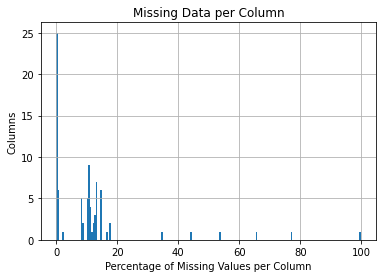

In [ ]:
# We then visualize with a Histogram to see the extreme outliers

percentage_of_missing_values = 100 * azdias.isnull().sum() / len(azdias)
plt.hist(percentage_of_missing_values, bins=200)
plt.ylabel('Columns')
plt.xlabel('Percentage of Missing Values per Column')
plt.title('Missing Data per Column')
plt.grid(True)
plt.show() 

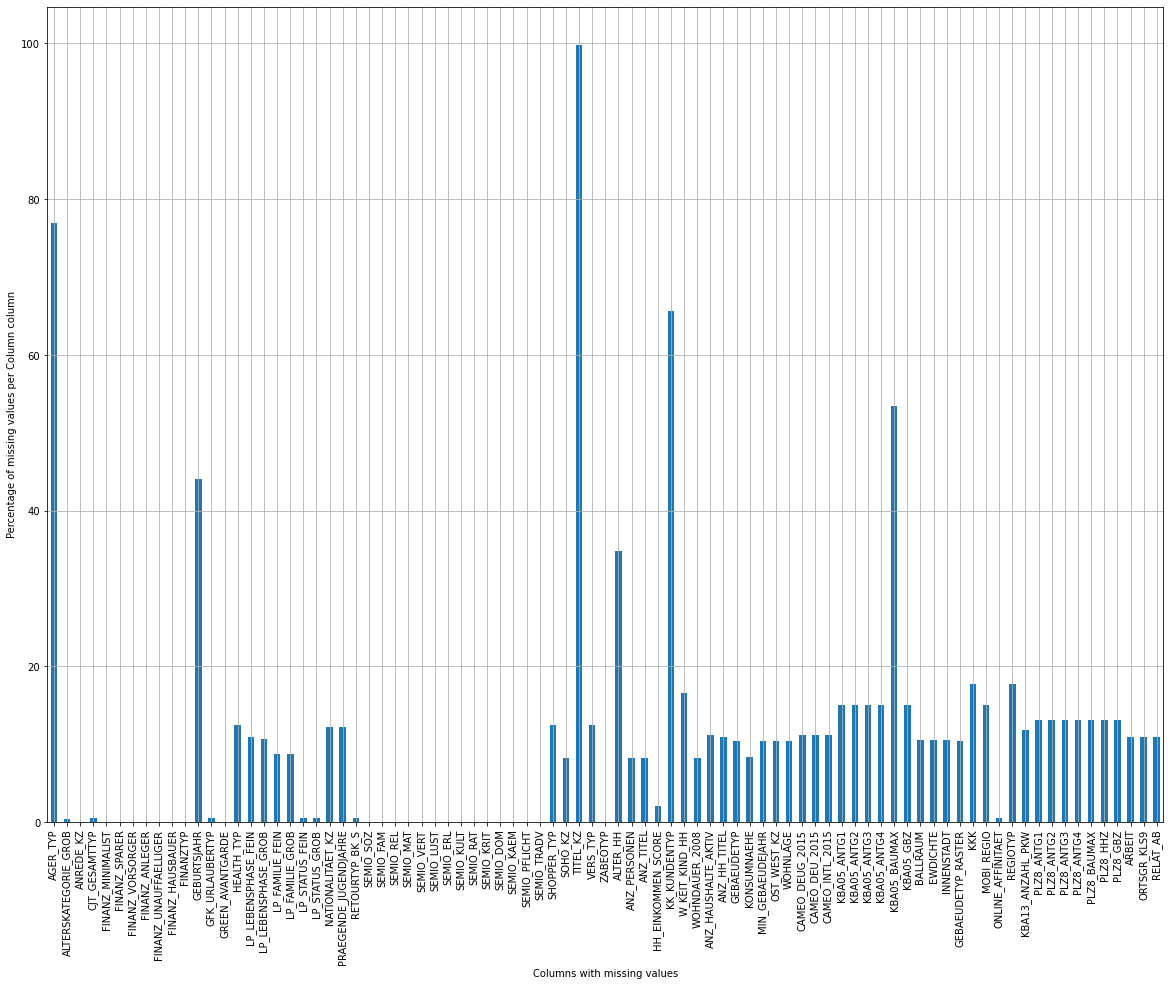

In [ ]:
# We can further visualize to see the particular columns
percentage_of_missing_values.plot.bar(figsize=(20,15))
plt.xlabel('Columns with missing values')
plt.ylabel('Percentage of missing values per Column column')
plt.grid(True)
plt.show()

In [ ]:
# We further visualize the missing values by sorting the particular columns in descending order to decide on which ones to remove
percentage_of_missing_values.sort_values(ascending=False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
KKK                      17.735668
REGIOTYP                 17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_ANTG1               13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
SHOPPER_TYP              12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

In [ ]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

over_18_percent_missing_values = percentage_of_missing_values[percentage_of_missing_values>18].index
print(over_18_percent_missing_values)

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


In [ ]:
# Here, we remove features that are missing more than 18% of their data. 
# Drop the outlier columns

outlier_columns = over_18_percent_missing_values

for col in outlier_columns:
    azdias.drop(col, axis=1, inplace=True)

In [ ]:
# We compute the percentage of missing values again to capture the new value now that the outliers have been removed
percentage_of_missing_values = 100 * azdias.isnull().sum() / len(azdias)

In [ ]:
# We check to see that the outlier columns with missing values above 18% were indeed removed
percentage_of_missing_values.sort_values(ascending=False)

KKK                      17.735668
REGIOTYP                 17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_ANTG1              14.959701
MOBI_REGIO               14.959701
KBA05_GBZ                14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
PLZ8_ANTG1               13.073637
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
SHOPPER_TYP              12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV      11.176913
CAMEO_INTL_2015          11.147852
CAMEO_DEUG_2015          11.147852
CAMEO_DEU_2015           11.147852
LP_LEBENSPHASE_FEIN      10.954859
RELAT_AB                 10.926022
ARBEIT              

#### Discussion 1.1.2: Assess Missing Data in Each Column

From our tables and visualizations, there are a total of 85 Columns and 891,221 Rows in our dataset. Out of these, there are 61 columns with missing values. Before conversion of the missing or unknown data that were read in as string objects to integers, there were 48,968,384,896,838 naturally missing values. After conversion, the total mising data increased to 83,739,298,373,929. This amount of missing data is quite substantial. 
We proceeded to visualize the 61 columns with missing values along with their percentages and values in the table on line 17. Out of the 61 columns with missing data, 6 columns (9.84%) of them had the most missing data ranging from 34% to 99% missing data. Also, 47 columns had between 17% and 8% of their data missing. These 47 columns account for about 77% of columns with missing data. The remaining 8 columns (accounting for 13% of columns with missing data) had insignificant missing values ranging from 2% to 0.5%. For this assesment, columns with more than 18 percent of their data missing were removed, as these were deemed to have minimal impact on the data. 
This resulted in 6 columns being removed, namely: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [ ]:
# How much data is missing in each row of the dataset?
# We count missing values along the rows (axis=1) using isnull().sum

missing_row_values=azdias.isnull().sum(axis=1)
missing_row_values.sort_values(inplace=True)


In [ ]:
missing_row_values.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

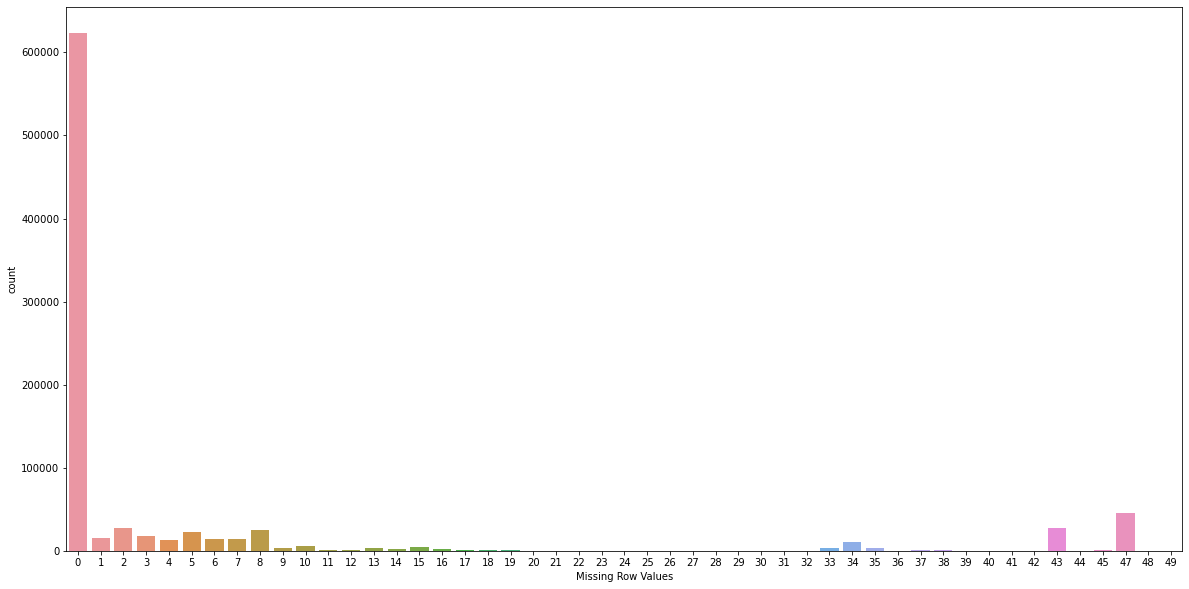

In [ ]:
# We plot the vizualization using seaborn to show the missing row values

plt.figure(figsize=(20,10))
ax = sns.countplot(missing_row_values)
ax.set_xlabel('Missing Row Values')
plt.show()


In [ ]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.


# We choose 10% threshold as 10.52% (93795 of 891221) of rows have missing values greater than 20%.

lower_threshold = azdias[azdias.isnull().sum(axis=1) <=10]
higher_threshold = azdias[azdias.isnull().sum(axis=1) >10]

In [ ]:
lower_threshold.shape

(780153, 79)

In [ ]:
higher_threshold.shape

(111068, 79)

In [ ]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# First, we explore the percentage of missing values in the two subsets
percentage_lower_threshold_missing_values = 100 * lower_threshold.isnull().sum() / len(lower_threshold)
print('These are the percentages of lower threshold values:\n\n{}\n'.format(percentage_lower_threshold_missing_values))
percentage_higher_threshold_missing_values = 100 * higher_threshold.isnull().sum() / len(higher_threshold)
print('These are the percentages of higher threshold values:\n\n{}'.format(percentage_higher_threshold_missing_values))

These are the percentages of lower threshold values:

ALTERSKATEGORIE_GROB     0.336472
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.491442
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
GFK_URLAUBERTYP          0.491442
GREEN_AVANTGARDE         0.000000
HEALTH_TYP               4.425286
LP_LEBENSPHASE_FEIN      5.969855
LP_LEBENSPHASE_GROB      5.626332
LP_FAMILIE_FEIN          3.697993
LP_FAMILIE_GROB          3.697993
LP_STATUS_FEIN           0.491442
LP_STATUS_GROB           0.491442
NATIONALITAET_KZ         4.088813
PRAEGENDE_JUGENDJAHRE    3.393437
RETOURTYP_BK_S           0.491442
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST               0.0

In [ ]:
# To Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# We first check the missing column values
columns_missing = percentage_of_missing_values[percentage_of_missing_values ==0].index
low_columns_missing = columns_missing[:]

low_columns_missing


Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')

In [ ]:
# We select 10 for comparison
low_columns_missing = columns_missing[:10]

In [ ]:
# We then create a countplot to compare the 10 selected

def create_plot(low_columns_missing):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(12)
    ax1.set_title('Higher Threshold Values')
    sns.countplot(azdias.loc[lower_threshold.index,low_columns_missing],ax=ax1)

    ax2.set_title('Lower Threshold Values')
    sns.countplot(azdias.loc[higher_threshold.index,low_columns_missing],ax=ax2)
    
    plt.show() 


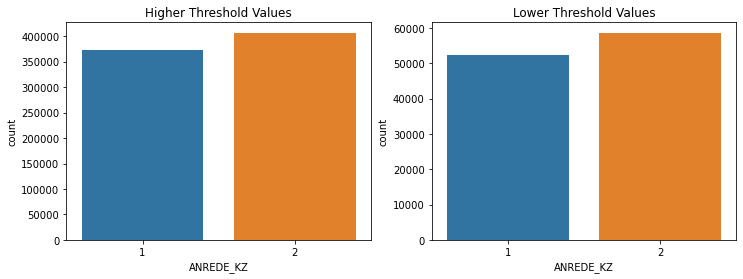

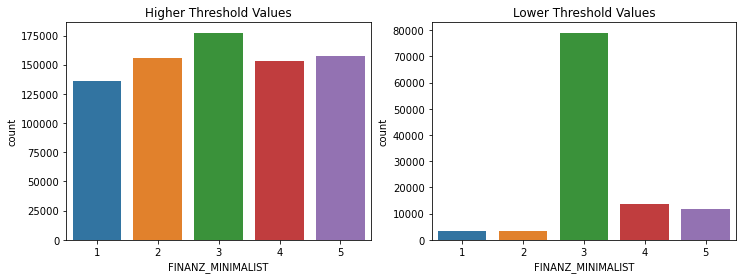

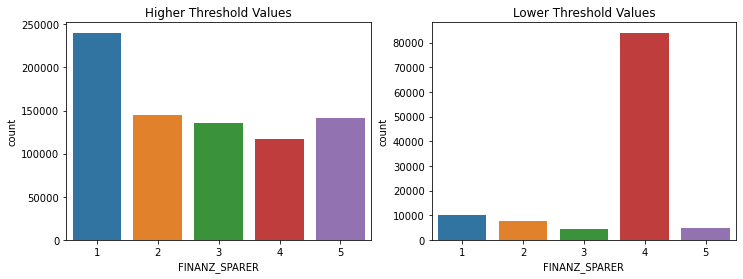

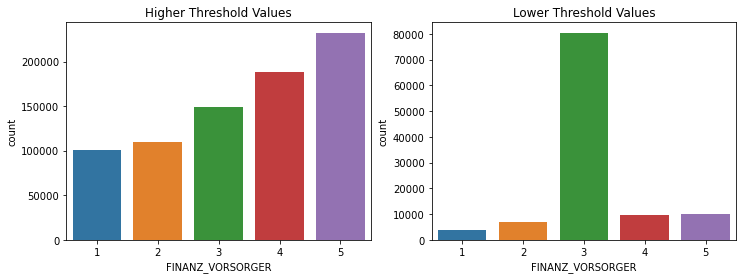

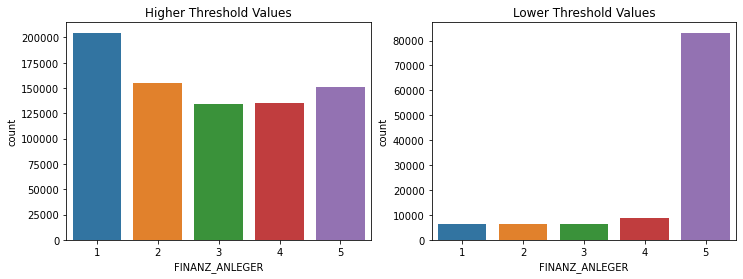

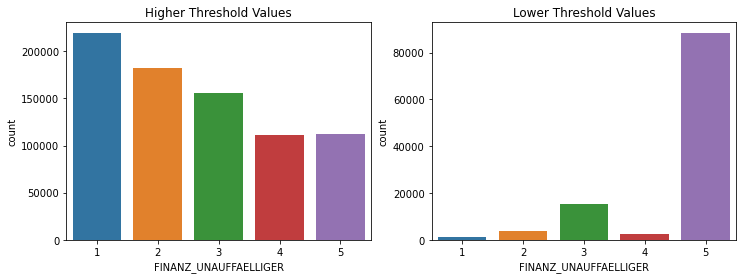

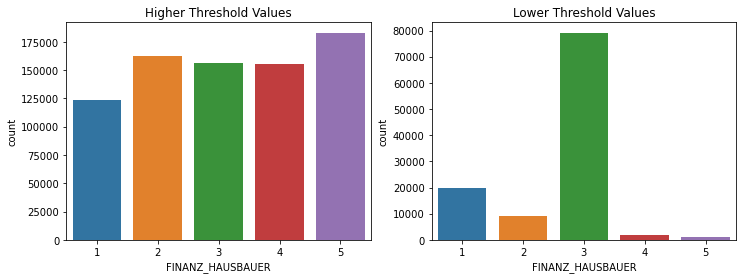

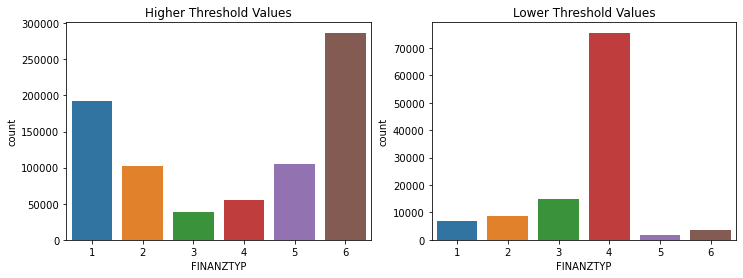

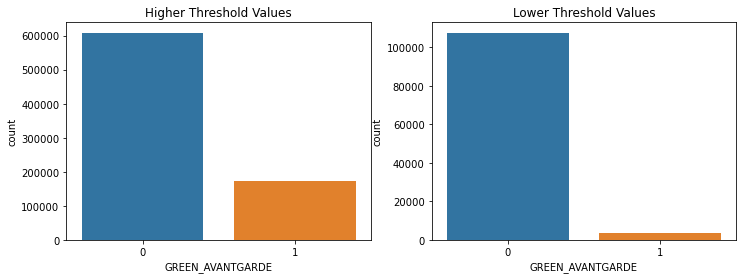

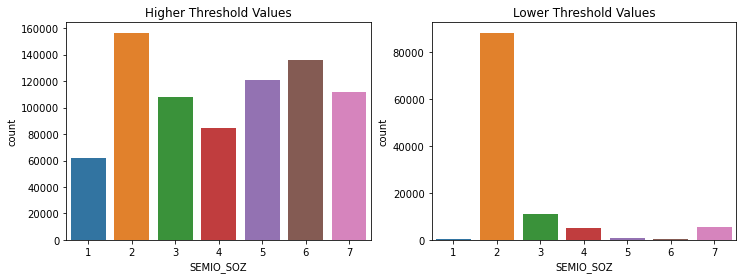

In [ ]:
for i in range(low_columns_missing.size):
    create_plot(low_columns_missing[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row

There is a significant amount of of rows with missing data, with the maximum rows missing values in 49 columns out of 79. We divide the data using a 10% threshold as 10.52% (93795 of 891221) of rows have missing values greater than 20%. This seems reasonable since missing data less than 20% may still provide us with useful informaton. The resulting subsets had lower missing values = 780,153 Rows and 79 columns, and the higher missing values subset = 111,068 rows and 79 columns.

As for the comparison between the data with lots of missing values and the data with few or no missing values, 10 comparisons were made. Overall, they are not much qualitatively different. Aside from ANDREDE_KZ which was similar for both categories, some insignificant comonalities were also observed in few cases such as for GREEN_AVANTGARDE and FINANZ_MINIMALISTFINANZ_MINIMALIST. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [ ]:
# How many features are there of each data type?

feat_info = feat_info[feat_info.attribute.isin(list(azdias.columns.values))]
feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [ ]:
# We can further view the data description

feat_info.describe

<bound method NDFrame.describe of                 attribute information_level         type missing_or_unknown
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categoric

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [ ]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_variables = feat_info[feat_info.type == 'categorical']
print(categorical_variables)

           attribute information_level         type missing_or_unknown
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical               [-1]
41          VERS_TYP            person  categorical               [-1]
42    

In [ ]:
# The different levels of binary, multi-level, and which one needs to be re-encoded can be viewed
binary_variables = []
multi_level_variables = []
for variables in categorical_variables.attribute.values:
    if lower_threshold[variables].nunique() > 2:
        multi_level_variables.append(variables)
    else:
        binary_variables.append(variables)

print('The following are binary variables:\n {}'.format(binary_variables))
print("")
print('The following are Multi-level variables:\n {}'.format(multi_level_variables))

The following are binary variables:
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

The following are Multi-level variables:
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [ ]:
# We can also view the Binary variables and their type
for col in binary_variables:
    print(lower_threshold[col].value_counts())

2    406643
1    373510
Name: ANREDE_KZ, dtype: int64
0    608462
1    171691
Name: GREEN_AVANTGARDE, dtype: int64
0.0    773607
1.0      6546
Name: SOHO_KZ, dtype: int64
2.0    389484
1.0    356145
Name: VERS_TYP, dtype: int64
W    614719
O    165434
Name: OST_WEST_KZ, dtype: int64


In [ ]:
# We can also view the Multi-level variables and their type
for col in multi_level_variables:
    print(lower_threshold[col].value_counts())

4.0    193491
3.0    143625
2.0    139638
5.0    109291
6.0     98948
1.0     91326
Name: CJT_GESAMTTYP, dtype: int64
6    286945
1    192639
5    104605
2    102294
4     55044
3     38626
Name: FINANZTYP, dtype: int64
12.0    125499
10.0    101312
8.0      81841
11.0     73887
5.0      69843
4.0      60146
9.0      55670
3.0      52892
1.0      50114
7.0      40008
2.0      39613
6.0      25494
Name: GFK_URLAUBERTYP, dtype: int64
1.0     395060
10.0    127197
2.0      96151
11.0     48219
8.0      21321
7.0      18691
4.0      11244
5.0      10975
9.0      10285
6.0       7762
3.0       4398
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    395060
5.0    185701
2.0     96151
4.0     47774
3.0     26617
Name: LP_FAMILIE_GROB, dtype: int64
1.0     204772
9.0     131071
2.0     109934
10.0    109300
4.0      73272
3.0      68384
6.0      28227
5.0      26343
8.0      15977
7.0       9039
Name: LP_STATUS_FEIN, dtype: int64
1.0    314706
2.0    167999
4.0    147048
5.0    109300
3.0     37266
Na

In [ ]:
# Re-encode categorical variable(s) to be kept in the analysis.

#  The binary variable "OST_WEST_KZ" will need to be encoded with Onehot encoding to take on numerical values. 
# We use the .replace and inplace=True to replace the column being changed, and avoid creating an extra column

lower_threshold.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);

In [ ]:
# We check again to view our changes on the Binary variables have taken effect
for col in binary_variables:
    print(lower_threshold[col].value_counts())

2    406643
1    373510
Name: ANREDE_KZ, dtype: int64
0    608462
1    171691
Name: GREEN_AVANTGARDE, dtype: int64
0.0    773607
1.0      6546
Name: SOHO_KZ, dtype: int64
2.0    389484
1.0    356145
Name: VERS_TYP, dtype: int64
0    614719
1    165434
Name: OST_WEST_KZ, dtype: int64


In [ ]:
# Dropping the multi-level features to keep things straightforward

for col in multi_level_variables:
    lower_threshold.drop(col, axis=1, inplace=True)
print('The following Multi-level variables have been dropped:\n {}'.format(multi_level_variables))

The following Multi-level variables have been dropped:
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


#### Discussion 1.2.1: Re-Encode Categorical Features

The dataset was found to have the following features for each data type:
    ordinal        49
    categorical    18
    numeric         6
    mixed           6
    categorical    18
    numeric         6
    mixed           6
Both binary and multi-level features were explored for their levels of categorical variables, of which 5 were binary, and 13 were multi-level features. 
As for the categorical variable(s) to be Re-encoded and kept in the analysis, the binary variable "OST_WEST_KZ" was re-encoded with Onehot encoding to take on numerical values. 
The 13 multi-level features were dropped to keep things straightforward.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [ ]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

lower_threshold['PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [ ]:
# Creating two variables based on the Data_Dictionary.md. 

# Interval-type variable for decade: generation by decade. This interval variable defines the
# decade values measured along a scale (of 40s to 90s) with equidistant points from each other.

generation_by_decade_map = {0: [1, 2], 
                            1: [3, 4],
                            2: [5, 6, 7],
                            3: [8, 9],
                            4: [10, 11, 12, 13], 
                            5: [14, 15]}

def generation_by_decade_map(decade):
    if decade in (1, 2):
        return 0
    elif decade in (3, 4):
        return 1
    elif decade in (5, 6, 7):
        return 2
    elif decade in (8, 9):
        return 3
    elif decade in (10, 11, 12, 13):
        return 4
    elif decade in (14, 15):
        return 5
    

In [ ]:
# Binary variable for movement between mainstream vs avantgrade.

movement_mainstream_vs_avantgarde = {0: [2, 4, 6, 7, 9, 11, 13, 15], 
                                     1: [1, 3, 5, 8, 10, 12, 14]}

def movement_mainstream_vs_avantgarde(movement):
    if movement in (2, 4, 6, 7, 9, 11, 13, 15):
        return 0
    elif movement in (1, 3, 5, 8, 10, 12, 14):
        return 1

In [ ]:
# Creating the two new variables to replace PRAEGENDE_JUGENDJAHRE, and dropping PRAEGENDE_JUGENDJAHRE.

lower_threshold['PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE'] = lower_threshold['PRAEGENDE_JUGENDJAHRE'].apply(generation_by_decade_map)
lower_threshold['PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT'] = lower_threshold['PRAEGENDE_JUGENDJAHRE'].apply(movement_mainstream_vs_avantgarde)
lower_threshold.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [ ]:
# We can check to ensure that our new variable was created
lower_threshold['PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE'].head()

1    5.0
2    5.0
3    3.0
4    3.0
5    1.0
Name: PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE, dtype: float64

In [ ]:
# We can check to ensure our new variable was created
lower_threshold['PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT'].head()

1    1.0
2    0.0
3    1.0
4    1.0
5    1.0
Name: PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT, dtype: float64

In [ ]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

lower_threshold['CAMEO_INTL_2015'].isnull().sum()

3656

In [ ]:
# Functions to break up the 'CAMEO_INTL_2015' two-digit codes by their 'tens'-place and 'ones'-place digits into two new 
# ordinal variables (wealth_status and life_stage) which is equivalent to just treating them as their raw numeric values.


#  This function first checks to ensure the digit is not nan, and then returns the first digit by index position 0 for wealth

def wealth_status(digit):
    if not pd.isna(digit):
        return int(str(digit)[0])
    else:
        return np.nan

#  This function first checks to ensure the digit is not nan, and returns the second digit by index position 1 for life stage    
def life_stage(digit):
    if not pd.isna(digit):
        return int(str(digit)[1])
    else:
        return np.nan

In [ ]:
# Creating the wealth variable and the life stage variable, and dropping the CAMEO_INTL_2015 variable.

lower_threshold['CAMEO_INTL_2015_WEALTH_STATUS'] = lower_threshold['CAMEO_INTL_2015'].apply(wealth_status)
lower_threshold['CAMEO_INTL_2015_LIFE_STAGE'] = lower_threshold['CAMEO_INTL_2015'].apply(life_stage)
lower_threshold.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)


In [ ]:
lower_threshold['CAMEO_INTL_2015_WEALTH_STATUS'].head()

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: CAMEO_INTL_2015_WEALTH_STATUS, dtype: float64

In [ ]:
lower_threshold.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT,CAMEO_INTL_2015_WEALTH_STATUS,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,5.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,5.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,3.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,3.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1.0,1.0,5.0,4.0


In [ ]:
# We can check the other mixed-value features
mixed_varibales = feat_info[feat_info.type=='mixed']
mixed_varibales

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [ ]:
# We create neighborhood_quality column for WOHNLAGE and re-encode
good_neighborhood = [1, 2, 3]
poor_neighborhood = [4, 5]
rural_neighborhood = [7, 8]

def neighborhood_quality (x):
    if not pd.isna (x):
        if x in good_neighborhood:
            return 0
        elif x in poor_neighborhood: 
            return 1
        elif x in rural_neighborhood: 
            return 2  
    else:
        return np.nan

In [ ]:
# We create neighborhood_quality column and drop the original WOHNLAGE column
lower_threshold['WOHNLAGE_NEIGHBORHOOD_QUALITY'] = lower_threshold['WOHNLAGE'].apply(neighborhood_quality)
lower_threshold.drop(['WOHNLAGE'], axis = 1, inplace=True)

In [ ]:
# We check to ensure our changes took effect
lower_threshold['WOHNLAGE_NEIGHBORHOOD_QUALITY'].head()

1    1.0
2    0.0
3    2.0
4    0.0
5    2.0
Name: WOHNLAGE_NEIGHBORHOOD_QUALITY, dtype: float64

In [ ]:
# We create building type column for PLZ8_BAUMAX and re-encode
family_home = [1, 2, 3, 4]
business_buildings = [5]

def building_type (x):
    if not pd.isna (x):
        if x in family_home:
            return 0
        elif x in business_buildings: 
            return 1
    else:
        return np.nan

In [ ]:
# We create building_type column and drop the original PLZ8_BAUMAX column
lower_threshold['PLZ8_BAUMAX_BUILDING_TYPE'] = lower_threshold['PLZ8_BAUMAX'].apply(building_type)
lower_threshold.drop(['PLZ8_BAUMAX'], axis = 1, inplace=True)

In [ ]:
lower_threshold['PLZ8_BAUMAX_BUILDING_TYPE'].head()

1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: PLZ8_BAUMAX_BUILDING_TYPE, dtype: float64

In [ ]:
# We drop LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB
lower_threshold.drop(['LP_LEBENSPHASE_FEIN'], axis = 1, inplace=True)
lower_threshold.drop(['LP_LEBENSPHASE_GROB'], axis = 1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

In terms of feature engineering the mixed-value features based on the Data_Dictionary, two new variables were engineered for "PRAEGENDE_JUGENDJAHRE". One of the variables was an Interval-type variable for generation by decade. This interval variable defines the decade values measured along a scale (of 40s to 90s) with equal distance from each point. The other engineered variable was a Binary variable for movement between mainstream vs avantgrade. These two new variables replaced PRAEGENDE_JUGENDJAHRE. Also, the old variable PRAEGENDE_JUGENDJAHRE was dropped.

Similarly, for "CAMEO_INTL_2015", two new variables were engineered. Functions were used to break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables named wealth_status and life_stage.

After checking the other mixed-value features, a new variable was engineered to replace WOHNLAGE and to capture the neighborhood_quality in terms of the dimensions: good_neighborhood = 0, poor_neighborhood = 1, and rural_neighborhood = 2. 
Similarly, a new variable was engineered to replace PLZ8_BAUMAX and re-encode the building_types into family_home = 0, and business_buildings = 1.

As for the variables LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB, although they capture the dimensions of life-stage, fine-scale, and rough-scale, which all seem to be important considerations; however, these dimensions are not clearly delineated in the Data_Dictionary coding, and are very hard to categorize clearly. Hence it was considered best to drop them and keep things straightforward.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# The required re-engineering tasks have beeen addressed 


In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# We check that our dataframe contains only the columns that should be passed to the algorithm functions
lower_threshold.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT,CAMEO_INTL_2015_WEALTH_STATUS,CAMEO_INTL_2015_LIFE_STAGE,WOHNLAGE_NEIGHBORHOOD_QUALITY,PLZ8_BAUMAX_BUILDING_TYPE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,4.0,3.0,5.0,4.0,5.0,1.0,5.0,1.0,1.0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,5.0,0.0,2.0,4.0,0.0,0.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,4.0,2.0,3.0,3.0,3.0,1.0,1.0,2.0,2.0,0.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,3.0,4.0,6.0,5.0,3.0,1.0,4.0,3.0,0.0,0.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,5.0,2.0,3.0,3.0,1.0,1.0,5.0,4.0,2.0,0.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [ ]:
def clean_data(customers):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
# Put in code here to execute all main cleaning steps:
# convert missing value codes into NaNs, ...    

    
    # From the fourth column of the feature attributes summary, the missing_or_unknown shows the missing values encoded as a
    # list (e.g. [-1,0]) that gets read in as a string object, we iterate through the data and convert to int by first
    # stripping brackets and splitting strings into lists in feat_info

    for i in range(len(feat_info)):
        missing_values = feat_info.iloc[i]['missing_or_unknown']
        missing_values = missing_values.strip('[')
        missing_values = missing_values.strip(']')
        missing_values = missing_values.split(sep=',')
        missing_values = [int(value)
                          if (value!='X' and value!='XX' and value!='') 
                          else value for value in missing_values]
    # We aslo modify the customer df by converting its missing values into Nans based on the changes applied to feature_info
    if missing_values != ['']:
        customers = customers.replace({feat_info.iloc[i]['attribute']: missing_values}, np.nan)
        
# remove selected columns and rows, ...

    # Here, we remove features that are missing more than 18% of their data. 
    # We Drop the outlier columns

    outlier_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
           'KBA05_BAUMAX']
   
    
    for col in outlier_columns:
        customers.drop(col, axis=1, inplace=True)
    print('The following outlier columns have been dropped:\n {}'.format(outlier_columns))
    
    # We divide the data into two subsets based on the number of missing alues in each row.
    # We choose 10% threshold as 10.52% (93795 of 891221) of rows have missing values greater than 20%

    lower_threshold_customers = customers[customers.isnull().sum(axis=1) <=10]
    higher_threshold_customers = customers[customers.isnull().sum(axis=1) >10]
    
    
    # We clean out the dataset of NaN values.
    lower_threshold_customers.dropna(axis=0, how='any', inplace=True)
    print('The remaining NaN values have been cleaned out:\n')
    
    # We interpolate to clear the new columns of any empty values
    for col in lower_threshold_customers.columns:
        lower_threshold_customers[col] = lower_threshold_customers[col].interpolate(limit_direction='both')
 

 # select, re-encode, and engineer column values.

    
    # Here, the different levels of binary, multi-level, and the varibles that need to be re-encoded can be viewed
    binary_variables = []
    multi_level_variables = []
    for variables in categorical_variables.attribute.values:
        if lower_threshold_customers[variables].nunique() > 2:
            multi_level_variables.append(variables)
        else:
            binary_variables.append(variables)

    print('The following are binary variables:\n {}'.format(binary_variables))
    print("")
    print('The following are Multi-level variables:\n {}'.format(multi_level_variables))
    
    #  The binary variable "OST_WEST_KZ" will need to be encoded with Onehot encoding to take on numerical values. 
    # We use the .replace and inplace=True to replace the column being changed, and avoid creating an extra column
    lower_threshold_customers.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);
    print('The OST_WEST_KZ binary variable has been re-encoded with Onehot encoding:\n')
    
    
    # Dropping the multi-level features to keep things straightforward    
    multi_level_variables = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 
  'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    for col in multi_level_variables:
        lower_threshold_customers.drop(col, axis=1, inplace=True)
    print('The following Multi-level variables have been dropped:\n {}'.format(multi_level_variables))
    
      
    # Interval-type variable for decade: generation by decade. This interval variable defines the
    # decade values measured along a scale (of 40s to 90s) with equidistant points from each other.
    def generation_by_decade_map(decade):
        if decade in (1, 2):
            return 0
        elif decade in (3, 4):
            return 1
        elif decade in (5, 6, 7):
            return 2
        elif decade in (8, 9):
            return 3
        elif decade in (10, 11, 12, 13):
            return 4
        elif decade in (14, 15):
            return 5
    # Binary variable for movement between mainstream vs avantgrade.
    def movement_mainstream_vs_avantgarde(movement):
        if movement in (2, 4, 6, 7, 9, 11, 13, 15):
            return 0
        elif movement in (1, 3, 5, 8, 10, 12, 14):
            return 1
    # Creating the two new variables to replace PRAEGENDE_JUGENDJAHRE, and dropping PRAEGENDE_JUGENDJAHRE.
    lower_threshold_customers['PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE'] = lower_threshold_customers['PRAEGENDE_JUGENDJAHRE'].apply(generation_by_decade_map)
    lower_threshold_customers['PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT'] = lower_threshold_customers['PRAEGENDE_JUGENDJAHRE'].apply(movement_mainstream_vs_avantgarde)
    lower_threshold_customers.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    print('The PRAEGENDE_JUGENDJAHRE_GEN_BY_DECAD and PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT Interval-type variables have been created, and PRAEGENDE_JUGENDJAHRE dropped:\n')
        
   # Functions to break up the 'CAMEO_INTL_2015' two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables 
    # (wealth_status and life_stage) which is equivalent to just treating them as their raw numeric values.
    #  This function first checks if the digit is not nan, and returns the first digit by index position 0 for wealth
    
    lower_threshold_customers["CAMEO_INTL_2015"] = pd.to_numeric(lower_threshold_customers.CAMEO_INTL_2015, errors='coerce')
    
    def wealth_status(digit):
        if not pd.isna(digit):
            return int(str(digit)[0])
        else:
            return np.nan

    #  This function first checks if the digit is not nan, and returns the second digit by index position 1 for life stage    
    def life_stage(digit):
        if not pd.isna(digit):
            return int(str(digit)[1])
        else:
            return np.nan
    # Creating the wealth variable and the life stage variable, and dropping the CAMEO_INTL_2015 variable.
    lower_threshold_customers['CAMEO_INTL_2015_WEALTH_STATUS'] = lower_threshold_customers['CAMEO_INTL_2015'].apply(wealth_status)
    lower_threshold_customers['CAMEO_INTL_2015_LIFE_STAGE'] = lower_threshold_customers['CAMEO_INTL_2015'].apply(life_stage)
    lower_threshold_customers.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)
    print('The CAMEO_INTL_2015_WEALTH_STATUS and CAMEO_INTL_2015_LIFE_STAGE ordinal-type variables have been created, and CAMEO_INTL_2015 dropped:\n')
          
    # We create neighborhood_quality column for WOHNLAGE and re-encode
    good_neighborhood = [1, 2, 3]
    poor_neighborhood = [4, 5]
    rural_neighborhood = [7, 8]

    def neighborhood_quality (x):
        if not pd.isna (x):
            if x in good_neighborhood:
                return 0
            elif x in poor_neighborhood: 
                return 1
            elif x in rural_neighborhood: 
                return 2  
        else:
            return np.nan
    # We create neighborhood_quality column and drop the original WOHNLAGE column
    lower_threshold_customers['WOHNLAGE_NEIGHBORHOOD_QUALITY'] = lower_threshold_customers['WOHNLAGE'].apply(neighborhood_quality)
    lower_threshold_customers.drop(['WOHNLAGE'], axis = 1, inplace=True)
    print('The WOHNLAGE_NEIGHBORHOOD_QUALITY variable has been created, and WOHNLAGE dropped:\n')
    
    # We create building type column for PLZ8_BAUMAX and re-encode
    family_home = [1, 2, 3, 4]
    business_buildings = [5]

    def building_type (x):
        if not pd.isna (x):
            if x in family_home:
                return 0
            elif x in business_buildings: 
                return 1
        else:
            return np.nan
    # We create building_type column and drop the original PLZ8_BAUMAX column
    lower_threshold_customers['PLZ8_BAUMAX_BUILDING_TYPE'] = lower_threshold_customers['PLZ8_BAUMAX'].apply(building_type)
    lower_threshold_customers.drop(['PLZ8_BAUMAX'], axis = 1, inplace=True)
    print('The PLZ8_BAUMAX_BUILDING_TYPE variable has been created, and PLZ8_BAUMAX dropped:\n')      
    
    
    # We drop LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB
    lower_threshold_customers.drop(['LP_LEBENSPHASE_FEIN'], axis = 1, inplace=True)
    lower_threshold_customers.drop(['LP_LEBENSPHASE_GROB'], axis = 1, inplace=True)
    print('The LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB have been dropped:\n')
          
    
    # We clean out the dataset of all remaining NaN values.
    lower_threshold_customers.dropna(axis=0, how='any', inplace=True)
    print('The remaining NaN values have been cleaned out:\n')
    
    
    # We make sure unnecessary characters are cleaned out
    lower_threshold_customers = lower_threshold_customers.replace(r'^\s*$', np.nan, regex=True)
    
    # We strip all empty spaces
    lower_threshold_customers.columns = lower_threshold_customers.columns.str.strip()
    
    # We ensure most of the columns have been converted to numeric data by calling:
    lower_threshold_customers.apply(lambda col:pd.to_numeric(col, errors='coerce'))
    lower_threshold_customers.dtypes  
    
    
    # We interpolate to clear the new columns of any empty values
    for col in lower_threshold_customers.columns:
        lower_threshold_customers[col] = lower_threshold_customers[col].interpolate(limit_direction='both')  
    
    
    customers_clean = lower_threshold_customers
        
# Return the cleaned dataframe.
    
    return customers_clean

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# We start our investigation by checking the total NaN in our data

lower_threshold.isnull().sum().sum()

540163

In [ ]:
#  To consider dropping them altogether, we use shape to check the number of rows before removing the remaining nans
lower_threshold.shape

(780153, 66)

In [ ]:
# We clean out the dataset of all remaining NaN values.

lower_threshold.dropna(axis=0, how='any', inplace=True)

In [ ]:
# We confirm our changes

lower_threshold.isnull().sum().sum()

0

In [ ]:
lower_threshold.isnull().values.any()

False

In [ ]:
lower_threshold.isnull().sum()

ALTERSKATEGORIE_GROB                   0
ANREDE_KZ                              0
FINANZ_MINIMALIST                      0
FINANZ_SPARER                          0
FINANZ_VORSORGER                       0
FINANZ_ANLEGER                         0
FINANZ_UNAUFFAELLIGER                  0
FINANZ_HAUSBAUER                       0
GREEN_AVANTGARDE                       0
HEALTH_TYP                             0
RETOURTYP_BK_S                         0
SEMIO_SOZ                              0
SEMIO_FAM                              0
SEMIO_REL                              0
SEMIO_MAT                              0
SEMIO_VERT                             0
SEMIO_LUST                             0
SEMIO_ERL                              0
SEMIO_KULT                             0
SEMIO_RAT                              0
SEMIO_KRIT                             0
SEMIO_DOM                              0
SEMIO_KAEM                             0
SEMIO_PFLICHT                          0
SEMIO_TRADV     

In [ ]:
# We interpolate to clear the new columns of any empty values

for col in lower_threshold.columns:
        lower_threshold[col] = lower_threshold[col].interpolate(limit_direction='both')

In [ ]:
# We then check the new shape

lower_threshold.shape

(623207, 66)

In [ ]:
lower_threshold.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT,CAMEO_INTL_2015_WEALTH_STATUS,CAMEO_INTL_2015_LIFE_STAGE,WOHNLAGE_NEIGHBORHOOD_QUALITY,PLZ8_BAUMAX_BUILDING_TYPE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,4.0,3.0,5.0,4.0,5.0,1.0,5.0,1.0,1.0,0.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,5.0,0.0,2.0,4.0,0.0,0.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,3.0,4.0,6.0,5.0,3.0,1.0,4.0,3.0,0.0,0.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,5.0,2.0,3.0,3.0,1.0,1.0,5.0,4.0,2.0,0.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,5.0,4.0,6.0,3.0,4.0,1.0,2.0,2.0,1.0,0.0


In [ ]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()

lower_threshold_ss = scaler.fit_transform(lower_threshold) # We Fit and transform the data at the same time

In [ ]:
# We create a dataframe
lower_threshold_ss = pd.DataFrame(lower_threshold_ss)

# We add column names again
lower_threshold_ss.columns = list(lower_threshold)

In [ ]:
lower_threshold_ss.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT,CAMEO_INTL_2015_WEALTH_STATUS,CAMEO_INTL_2015_LIFE_STAGE,WOHNLAGE_NEIGHBORHOOD_QUALITY,PLZ8_BAUMAX_BUILDING_TYPE
0,-1.746288,0.977825,-1.512222,1.581057,-1.045044,1.539061,1.047076,1.340484,-0.553666,1.04465,...,0.583438,-0.201171,-0.171837,0.656460,1.164453,0.553666,1.147883,-1.251113,0.367187,-0.388306
1,0.202110,0.977825,-1.512222,0.900443,-1.765052,-0.531625,0.318375,1.340484,1.806142,1.04465,...,0.583438,-0.201171,-0.171837,-0.823840,1.164453,-1.806142,-0.909998,0.749822,-0.875413,-0.388306
2,0.202110,-1.022678,0.692400,0.219829,0.394973,-1.221854,0.318375,-0.856541,-0.553666,1.04465,...,-0.314763,0.809748,0.263756,1.396611,-0.213395,0.553666,0.461923,0.082844,-0.875413,-0.388306
3,-1.746288,0.977825,-0.042474,-1.141400,1.114982,-0.531625,-0.410326,1.340484,-0.553666,1.04465,...,1.481638,-1.212089,-1.043025,-0.083690,-1.591243,0.553666,1.147883,0.749822,1.609788,-0.388306
4,-0.772089,0.977825,-1.512222,1.581057,-1.765052,1.539061,1.047076,-0.124199,-0.553666,-0.27349,...,1.481638,0.809748,0.263756,-0.083690,0.475529,0.553666,-0.909998,-0.584135,0.367187,-0.388306


### Discussion 2.1: Apply Feature Scaling

We applied feature scaling to the general demogrphics dataset by calling fit_transform. But first, we explored the data again and cleaned it of all remaining Nan values, and interpolated to clear all columns of any empty values. We then applied feature scaling to the portion of the general population demographics data with no missing values by calling StandardScaler().fit_transform to both fit and transform the data at the same time. We preceeded to recreate the dataframe and add the column names again. The resulting dataframe has 623207 rows and 66 features.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
# Apply PCA to the scaled general population data.

pca = PCA()
lower_threshold_pca = pca.fit_transform(lower_threshold_ss)

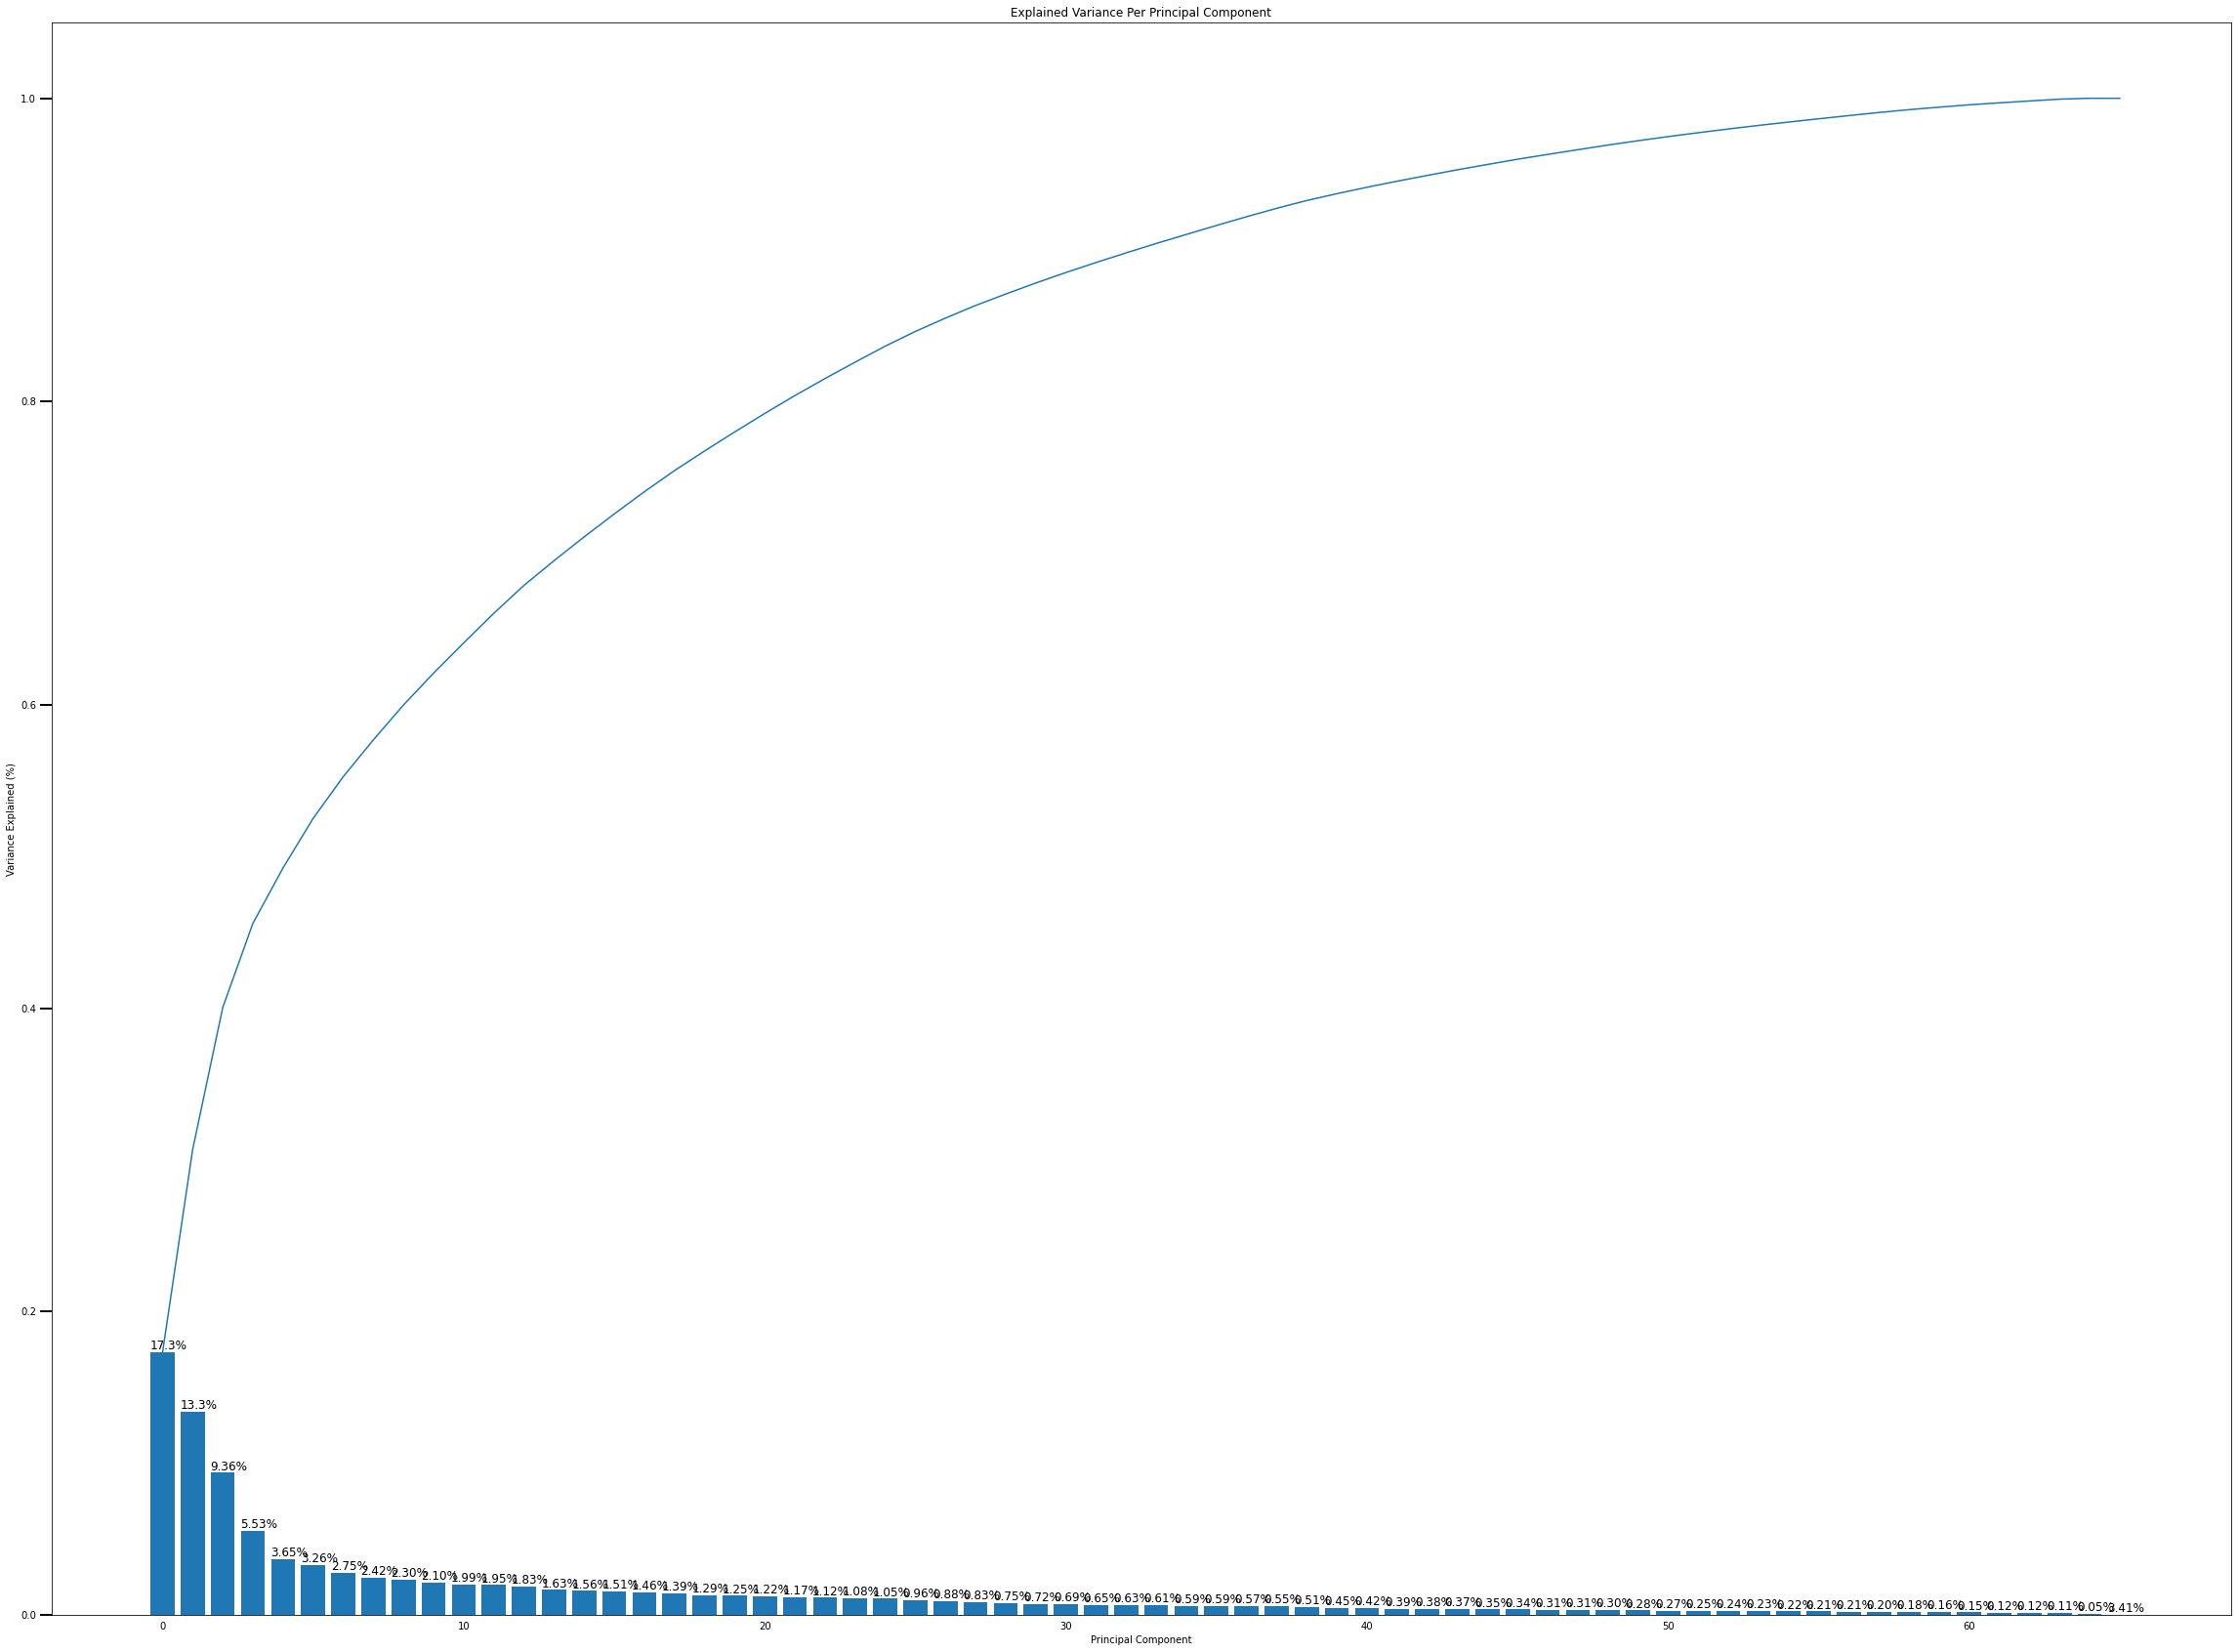

In [ ]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    This function creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(40, 30))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

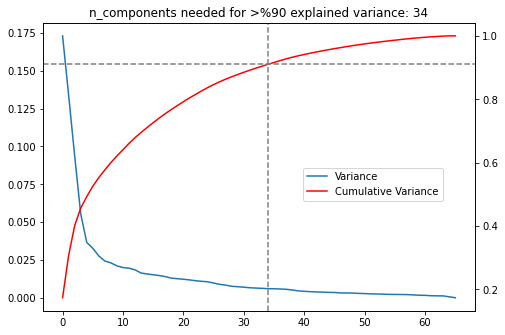

In [ ]:
# Number of components necessary to explain %90 variance:

def pca_plot2(pca):

    n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.90)[0]+1)

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1],True)
    ax2 = ax.twinx()
    ax.plot(pca.explained_variance_ratio_, label='Variance',)
    ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'red');
    ax.set_title('n_components needed for >%90 explained variance: {}'.format(n_components));
    ax.axvline(n_components, linestyle='dashed', color='grey')
    ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='grey')
    fig.legend(loc=(0.6,0.4));

pca_plot2(pca)

In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.

# We retain 34 components to obtain >90% of explained variance
pca = PCA(n_components=34)
lower_threshold_pca = pca.fit_transform(lower_threshold_ss) 
pca.explained_variance_ratio_.sum()*100

90.41578732208183

In [ ]:
# We can see how the highest explained variance of over 17% is captured by the first principal component, and decreases 
# down to the 34th component
print(pca.explained_variance_ratio_*100)

[17.30079517 13.3819674   9.36734103  5.53913849  3.65349569  3.26461586
  2.75621303  2.42343538  2.3006394   2.10313368  1.99191822  1.9524147
  1.83901915  1.63020202  1.56828064  1.5148582   1.46492782  1.39208277
  1.29460378  1.25505783  1.22212326  1.17653161  1.12399439  1.08213112
  1.05409487  0.96878285  0.88168386  0.83009388  0.75371582  0.72522399
  0.69252802  0.65721307  0.63517993  0.61835039]


### Discussion 2.2: Perform Dimensionality Reduction

Without initially adjusting any parameter, we apply PCA to the scaled general population data to investigate the variance accounted for by each principal component. 
We find that the highest explained variance of over 17% is captured by the first principal component. We further compute the number of components necessary to explain over %90 variance. 
We find that 34 components are required to obtain >90% of explained variance, with the highest explained variance of over 17% being captured by the first principal component and decreases down to the 34th component. 
Hence, we re-apply PCA to the data while retaining 34 components to obtain 90.41% of explained variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.


# Function Mapping the weights of each of the 34 principal component relations with corresponding features, and plotting the 
# weight to feature relationships:
def pca_weight_map(i, visualize=True):
    weight_to_feature = pd.DataFrame(pca.components_,columns=lower_threshold_ss.columns).T
    print("The sorted Weights Mapping Principal Component {} to corresponding feature names are as follows:\n".format(i+1))
    print(weight_to_feature[i].sort_values(ascending=False))
    
    # Plotting the weight to feature relationships
    if visualize:
        weight_to_feature.plot(kind='bar', 
                  title="The Weights Mapping Principal Component {} to corresponding feature names\n".format(i+1),
                  figsize=(20, 10)).legend(loc=(1,0));
        print("\n")
        plt.show()

The sorted Weights Mapping Principal Component 1 to corresponding feature names are as follows:

PLZ8_ANTG3                             0.217169
PLZ8_ANTG4                             0.212126
CAMEO_INTL_2015_WEALTH_STATUS          0.196364
HH_EINKOMMEN_SCORE                     0.191319
ORTSGR_KLS9                            0.191055
EWDICHTE                               0.187293
FINANZ_SPARER                          0.152817
KBA05_ANTG4                            0.148592
FINANZ_HAUSBAUER                       0.146857
PLZ8_ANTG2                             0.142973
PLZ8_BAUMAX_BUILDING_TYPE              0.141250
ARBEIT                                 0.139746
ANZ_HAUSHALTE_AKTIV                    0.131720
KBA05_ANTG3                            0.130355
RELAT_AB                               0.127418
SEMIO_PFLICHT                          0.121613
SEMIO_REL                              0.118792
PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE    0.114058
PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT      

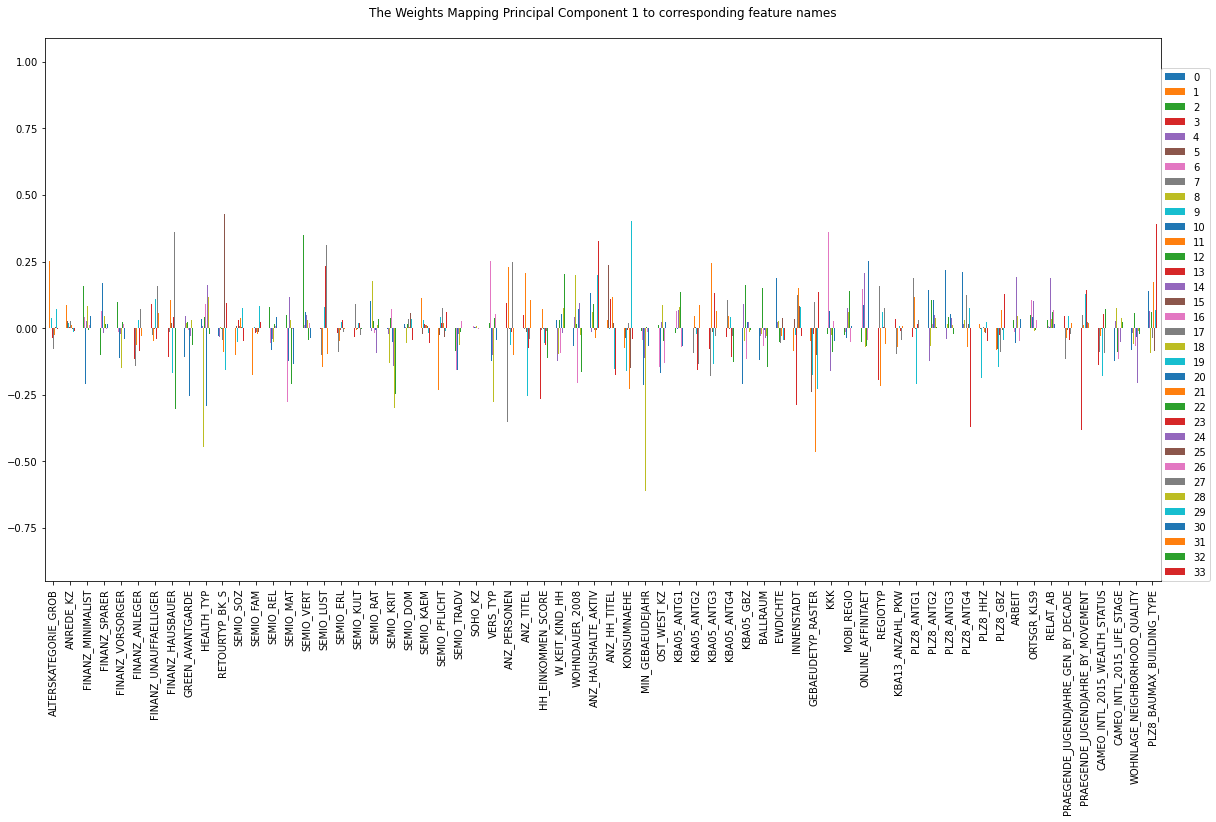

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_map(0)

The sorted Weights Mapping Principal Component 2 to corresponding feature names are as follows:

ALTERSKATEGORIE_GROB                   0.252775
SEMIO_ERL                              0.227735
FINANZ_VORSORGER                       0.221108
SEMIO_LUST                             0.175126
RETOURTYP_BK_S                         0.162988
SEMIO_KRIT                             0.119931
FINANZ_HAUSBAUER                       0.119892
W_KEIT_KIND_HH                         0.117732
SEMIO_KAEM                             0.111489
PLZ8_ANTG3                             0.105693
ORTSGR_KLS9                            0.103434
EWDICHTE                               0.103156
PLZ8_ANTG4                             0.101698
ANREDE_KZ                              0.087465
CAMEO_INTL_2015_WEALTH_STATUS          0.078667
ARBEIT                                 0.075738
KBA05_ANTG4                            0.073807
RELAT_AB                               0.071175
PLZ8_ANTG2                             

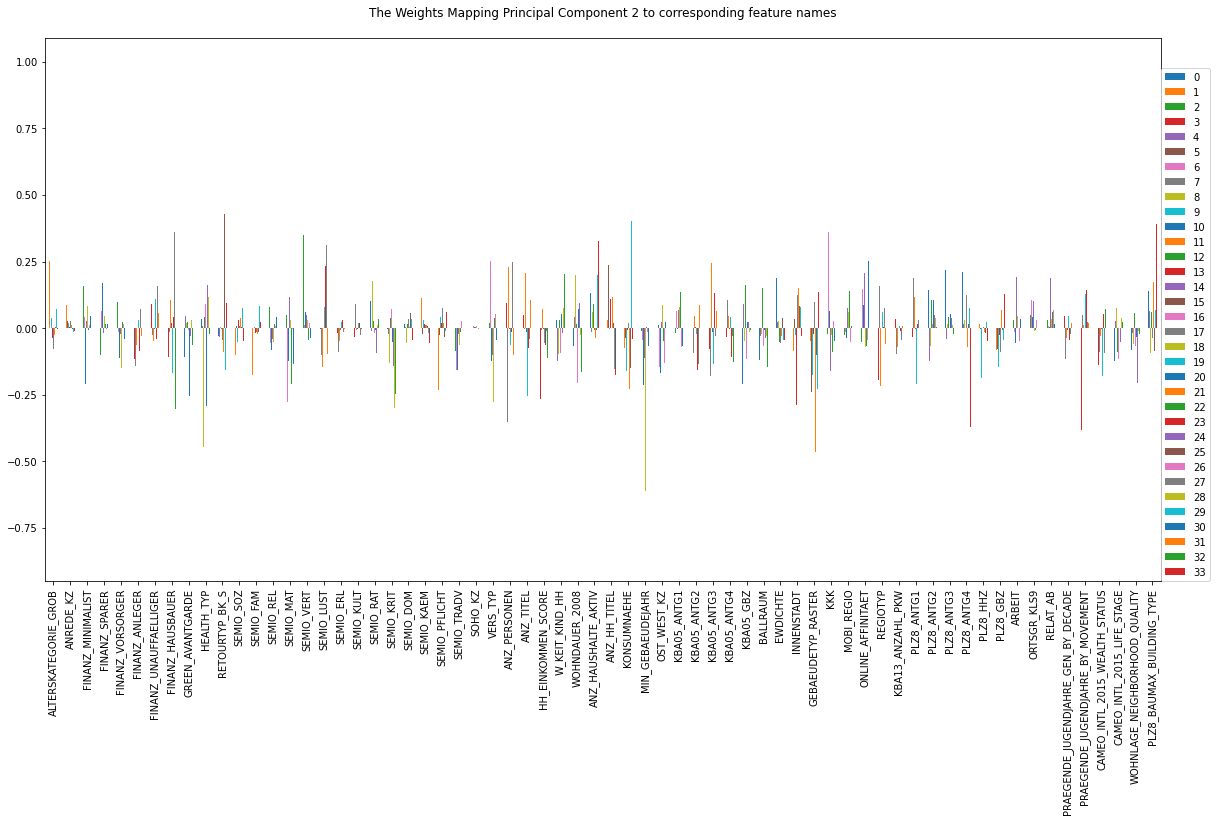

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_map(1)

The sorted Weights Mapping Principal Component 3 to corresponding feature names are as follows:

SEMIO_VERT                             0.348759
SEMIO_SOZ                              0.263745
SEMIO_FAM                              0.251677
SEMIO_KULT                             0.232123
FINANZ_MINIMALIST                      0.159976
RETOURTYP_BK_S                         0.114125
FINANZ_VORSORGER                       0.097022
W_KEIT_KIND_HH                         0.092092
ALTERSKATEGORIE_GROB                   0.080920
SEMIO_REL                              0.077512
SEMIO_LUST                             0.072784
GREEN_AVANTGARDE                       0.056724
SEMIO_MAT                              0.049135
ORTSGR_KLS9                            0.047857
EWDICHTE                               0.047737
PLZ8_ANTG4                             0.043321
PLZ8_ANTG3                             0.042030
PLZ8_BAUMAX_BUILDING_TYPE              0.036182
WOHNDAUER_2008                         

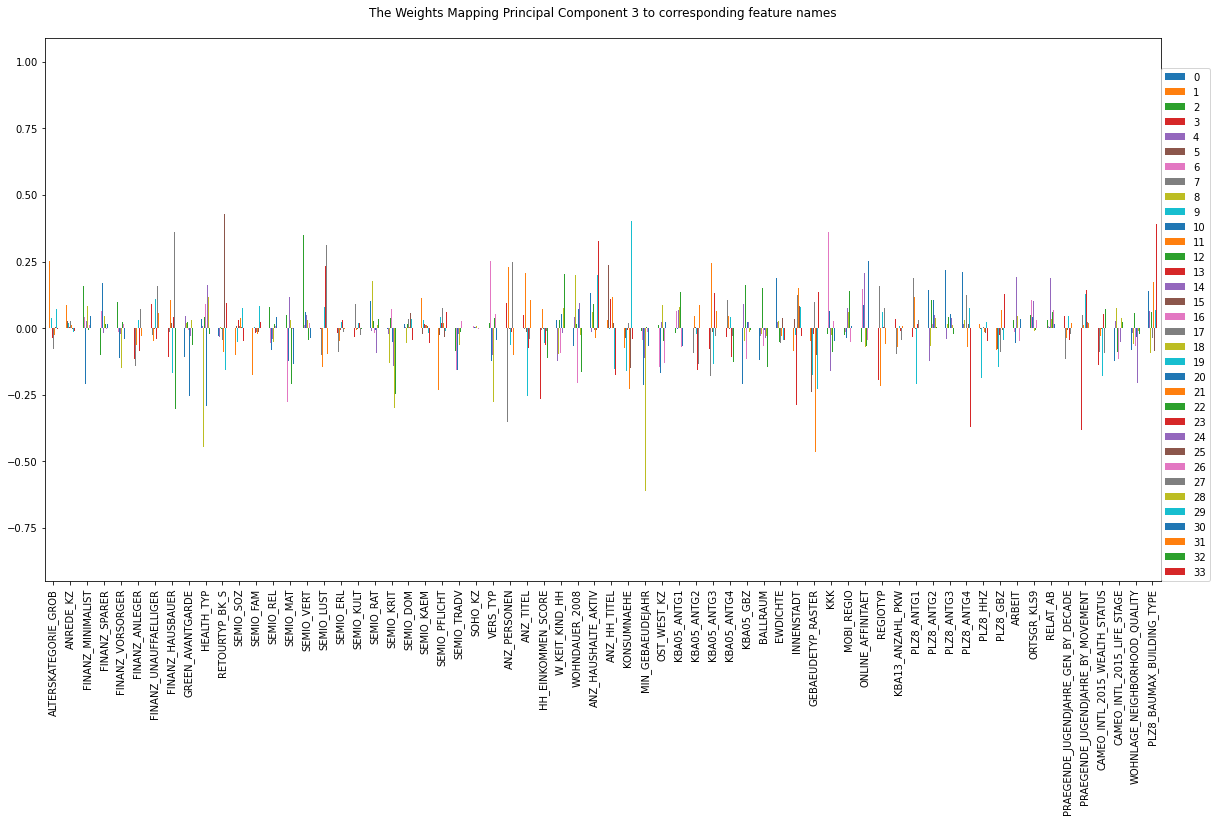

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_map(2)

### Discussion 2.3: Interpret Principal Components

We define a function to map the weights of each of the first 3 of the 34 principal components in terms of their relations with corresponding features, and we plot the weight to feature relationships.From the mapped weights of the principal components to corresponding feature names, we print out the linked values sorted by weight.

For the first principal component, we observe that 38 variables have various slight positive correlations to the principal component with values ranging from 0.217169 to 0.006214, with the most positive contribution being from PLZ8_ANTG3 with 0.217169 and PLZ8_ANTG4 with 0.212126. The remaining variables have various slight negative correlations with values ranging from -0.002094 to -0.234046, with the most negative contribution to the principal component being from MOBI_REGIO. 

Similarly, for the second principal component, we observe that 34 variables are slightly positively correlated to the principal component with values ranging from 0.252775 to 0.004826, with the most positive contribution being from ALTERSKATEGORIE_GROB. The remaining variables are slightly negatively correlated with values ranging from -0.002285 to -0.257430, with SEMIO_REL having the most negative contribution to the principla component.

As for the third observed principal component, we see that 32 variables are slightly possitively correlated with values ranging from 0.348759 to 0.000567, with the most positive contribution being from SEMIO_VERT. The remaining variables are slightly negatively correlated with values ranging from -0.002855 to -0.367882, with ANREDE_KZ having the most negative contribution.

The general trend appears to be that the number of features that contribute positively to each principal component reduces as we traverse down the principal components.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...
    
def kmeans_score(lower_threshold_pca, center):
    '''
    Returns the kmeans score of average difference from each point to its assigned cluster's center using SSE to compute points to centers
    INPUT:
        data - the PCA-transformed data
        center - the number of centers (k values)
    OUTPUT:
        score - SSE score
    '''

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters = center, random_state = 1414)
    model = kmeans.fit(lower_threshold_pca)  # fit the model
    # compute the average within-cluster distances.
    score = np.abs(model.score(lower_threshold_pca))
    
    return score    


In [ ]:
# For k (number of clusters) the Sum of Squared Errors (SSE) is the mean or average distance of each data point from the center
# of the cluster or centroid across all of the clusters

scores = [] 
centers = list(range(1,28,2))

for center in centers:
    scores.append(kmeans_score(lower_threshold_pca, center))
    print('For k_value of {}, the  average distances between each value of k and the average distance to cluster centroid is: {}'.format(center, scores))

For k_value of 1, the  average distances between each value of k and the average distance to cluster centroid is: [37189516.03595798]
For k_value of 3, the  average distances between each value of k and the average distance to cluster centroid is: [37189516.03595798, 29099510.039133813]
For k_value of 5, the  average distances between each value of k and the average distance to cluster centroid is: [37189516.03595798, 29099510.039133813, 26258465.693883296]
For k_value of 7, the  average distances between each value of k and the average distance to cluster centroid is: [37189516.03595798, 29099510.039133813, 26258465.693883296, 24349815.63454062]
For k_value of 9, the  average distances between each value of k and the average distance to cluster centroid is: [37189516.03595798, 29099510.039133813, 26258465.693883296, 24349815.63454062, 23120925.855681133]
For k_value of 11, the  average distances between each value of k and the average distance to cluster centroid is: [37189516.0359579

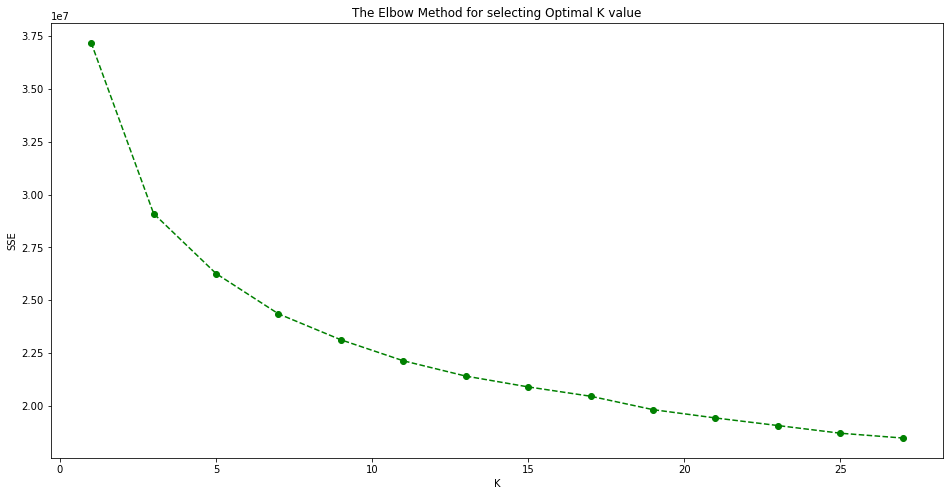

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# We use the Elbow method to select the optimal value of K.

plt.figure(figsize=(16,8))
plt.plot(centers, scores, linestyle='--', marker='o', color='g');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('The Elbow Method for selecting Optimal K value');

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.


# We instantiate the model with 21 centers based on the optimal k identified by the Elbow method
kmeans = KMeans(n_clusters = 21, random_state = 1414)
# fit the model to the data
model = kmeans.fit(lower_threshold_pca)
# We predict the labels on the same dataset to show the category that points belong to .
general_population_pred = model.predict(lower_threshold_pca)

### Discussion 3.1: Apply Clustering to General Population

We use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data. We then compute the average difference from each point to its assigned cluster's center by using the KMeans object's .score() method. We test for cluster counts through 28 clusters to get the full picture, we print out the  average distance between each value of k and the average distance to cluster centroid and observe that the value gets smaller as the number of points increases.

We then use the Elbow method to determine, visualize, and and select the optimal number of clusters for our dataset. From the elbow method, we determine the optimal value of K to be 21. We proceed to re-fit a KMeans instance to perform the clustering operation on 21 cluster assignments for the general demographics data as determined by the elbow method.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [ ]:
customers.shape

(191652, 85)

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

The following outlier columns have been dropped:
 ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
The remaining NaN values have been cleaned out:

The following are binary variables:
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

The following are Multi-level variables:
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
The OST_WEST_KZ binary variable has been re-encoded with Onehot encoding:

The following Multi-level variables have been dropped:
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
The PRAEGENDE_JUGENDJAHRE_GEN_BY_DECAD and PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT Interval-ty

In [ ]:
customers_clean.shape

(122543, 66)

In [ ]:
customers_clean.isnull().sum().sum()

0

In [ ]:
customers_clean = customers_clean.astype(float)

In [ ]:
# We select only numericals to scale
customers_clean.select_dtypes(include='float64').columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEI

In [ ]:
# We check the data before scaling
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT,CAMEO_INTL_2015_WEALTH_STATUS,CAMEO_INTL_2015_LIFE_STAGE,WOHNLAGE_NEIGHBORHOOD_QUALITY,PLZ8_BAUMAX_BUILDING_TYPE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,5.0,1.0,2.0,1.0,1.0,0.0,1.0,3.0,2.0,0.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,2.0,3.0,5.0,3.0,1.0,0.0,3.0,4.0,0.0,0.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,3.0,3.0,5.0,1.0,3.0,1.0,4.0,1.0,0.0,0.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,5.0,3.0,7.0,5.0,1.0,0.0,3.0,4.0,0.0,0.0
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,5.0,2.0,3.0,2.0,1.0,0.0,2.0,3.0,2.0,0.0


In [ ]:
# We transform the 
customers_clean_scaled=scaler.transform(customers_clean)

In [ ]:
# We create a dataframe
customers_clean_scaled=pd.DataFrame(customers_clean_scaled)

# We add column names again
customers_clean_scaled.columns = list(customers_clean)

In [ ]:
# We check to confirm that the data is indeed scaled and transformed
customers_clean_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT,CAMEO_INTL_2015_WEALTH_STATUS,CAMEO_INTL_2015_LIFE_STAGE,WOHNLAGE_NEIGHBORHOOD_QUALITY,PLZ8_BAUMAX_BUILDING_TYPE
0,1.176308,-1.022678,1.427274,-1.1414,1.114982,-1.221854,-0.410326,-0.856541,1.806142,-1.59163,...,1.481638,-2.223008,-1.478619,-1.563991,-1.591243,-1.806142,-1.595958,0.082844,1.609788,-0.388306
1,1.176308,0.977825,1.427274,-1.1414,1.114982,-1.221854,1.047076,0.608142,1.806142,-0.27349,...,-1.212964,-0.201171,-0.171837,-0.083690,-1.591243,-1.806142,-0.224037,0.749822,-0.875413,-0.388306
2,0.202110,-1.022678,-0.042474,-1.1414,0.394973,0.848832,1.775777,-0.856541,-0.553666,1.04465,...,-0.314763,-0.201171,-0.171837,-1.563991,-0.213395,0.553666,0.461923,-1.251113,-0.875413,-0.388306
3,0.202110,-1.022678,1.427274,-1.1414,1.114982,-1.221854,-0.410326,-0.124199,1.806142,1.04465,...,1.481638,-0.201171,0.699350,1.396611,-1.591243,-1.806142,-0.224037,0.749822,-0.875413,-0.388306
4,1.176308,-1.022678,1.427274,-1.1414,1.114982,-1.221854,-1.139027,-0.856541,1.806142,-0.27349,...,1.481638,-1.212089,-1.043025,-0.823840,-1.591243,-1.806142,-0.909998,0.082844,1.609788,-0.388306


In [ ]:
# Using pca object to transform to the customers data
customers_clean_pca = pca.transform(customers_clean_scaled)

In [ ]:
# We predict using the kmeans object
customers_clean_pred = model.predict(customers_clean_pca)
pca.explained_variance_ratio_.sum()*100

90.41578732208183

In [ ]:
# We can see how the highest explained variance of over 17% is captured by the first principal component, and decreases 
# down to the 34th component
print(pca.explained_variance_ratio_*100)

[17.30079517 13.3819674   9.36734103  5.53913849  3.65349569  3.26461586
  2.75621303  2.42343538  2.3006394   2.10313368  1.99191822  1.9524147
  1.83901915  1.63020202  1.56828064  1.5148582   1.46492782  1.39208277
  1.29460378  1.25505783  1.22212326  1.17653161  1.12399439  1.08213112
  1.05409487  0.96878285  0.88168386  0.83009388  0.75371582  0.72522399
  0.69252802  0.65721307  0.63517993  0.61835039]


In [ ]:
customers_clean_pred

array([19,  7,  2, ..., 19, 10,  1])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# We visualize with a table of population count of the general population against the customer population
customers_clean_pred = pd.Series(customers_clean_pred)
customers_dist = customers_clean_pred.value_counts().sort_index()
general_population_pred = pd.Series(general_population_pred)
general_population_dist = general_population_pred.value_counts().sort_index()
datapoint_distribution = pd.DataFrame([general_population_dist,customers_dist]).T
datapoint_distribution.columns = ['Proportion of data points in General population clusters', 'Proportion of data points in customer clusters']
datapoint_distribution

,Proportion of data points in General population clusters,Proportion of data points in customer clusters
0,38144,2076
1,30412,15597
2,44503,3408
3,32959,870
4,31140,8963
5,34986,7743
6,40643,607
7,38314,13560
8,24752,496
9,24880,3433


In [ ]:
# We visualize the percentages in cluster representation between groups
customers_dist = 100 * (customers_clean_pred.value_counts().sort_index()) / len(customers_clean_pred)
general_population_dist = 100 * (general_population_pred.value_counts().sort_index())/ len(general_population_pred)

datapoint_distribution = pd.DataFrame([general_population_dist,customers_dist]).T
datapoint_distribution.columns = ['Percentage of data points in General population clusters', 'Percentage of data points in customer clusters']
datapoint_distribution

,Percentage of data points in General population clusters,Percentage of data points in customer clusters
0,6.120599,1.694099
1,4.879920,12.727777
2,7.140966,2.781065
3,5.288612,0.709955
4,4.996735,7.314167
5,5.613865,6.318598
6,6.521589,0.495336
7,6.147877,11.065504
8,3.971714,0.404756
9,3.992253,2.801466


Text(0.5, 1.0, 'Customers Clusters')

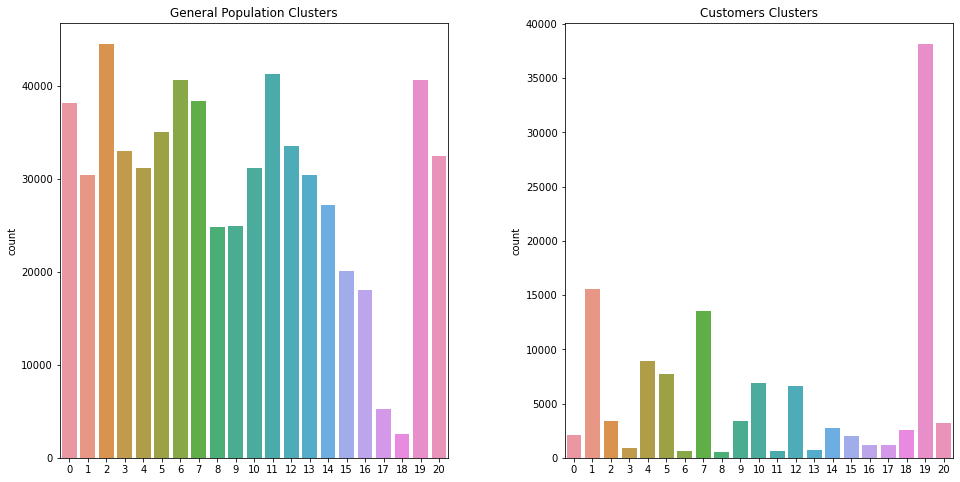

In [ ]:
# We visualize with a countplot for population count of the general population against the customer population
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (16,8))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(general_population_pred, ax=axs[0])
axs[0].set_title('General Population Clusters')
sns.countplot(customers_clean_pred, ax=axs[1])
axs[1].set_title('Customers Clusters')

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_17 = scaler.inverse_transform(pca.inverse_transform(customers_clean_pca[np.where(customers_clean_pred==17)])).round()
overrepresented_cluster = pd.DataFrame(data=cluster_17, index=np.array(range(0, cluster_17.shape[0])), columns=customers_clean.columns)
overrepresented_cluster.head(20)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT,CAMEO_INTL_2015_WEALTH_STATUS,CAMEO_INTL_2015_LIFE_STAGE,WOHNLAGE_NEIGHBORHOOD_QUALITY,PLZ8_BAUMAX_BUILDING_TYPE
0,4.0,2.0,3.0,1.0,5.0,3.0,1.0,5.0,-0.0,2.0,...,4.0,3.0,4.0,2.0,1.0,1.0,3.0,5.0,-0.0,-0.0
1,4.0,1.0,5.0,2.0,4.0,3.0,2.0,1.0,-0.0,2.0,...,5.0,1.0,1.0,1.0,3.0,1.0,2.0,3.0,2.0,0.0
2,4.0,2.0,3.0,1.0,6.0,2.0,1.0,5.0,-0.0,1.0,...,4.0,3.0,5.0,3.0,1.0,1.0,4.0,4.0,0.0,0.0
3,4.0,2.0,5.0,1.0,5.0,2.0,1.0,3.0,1.0,2.0,...,5.0,3.0,5.0,2.0,1.0,-0.0,2.0,3.0,0.0,-0.0
4,3.0,1.0,5.0,1.0,5.0,2.0,2.0,1.0,0.0,3.0,...,4.0,1.0,5.0,0.0,3.0,1.0,2.0,4.0,1.0,-0.0
5,4.0,2.0,4.0,1.0,5.0,2.0,2.0,3.0,0.0,1.0,...,3.0,3.0,3.0,4.0,1.0,1.0,3.0,4.0,2.0,-0.0
6,4.0,1.0,3.0,1.0,5.0,2.0,1.0,4.0,-0.0,1.0,...,3.0,3.0,6.0,3.0,2.0,1.0,4.0,4.0,0.0,-0.0
7,4.0,1.0,5.0,0.0,5.0,0.0,1.0,3.0,1.0,2.0,...,5.0,1.0,4.0,0.0,1.0,-0.0,2.0,4.0,0.0,-0.0
8,4.0,1.0,3.0,3.0,3.0,2.0,2.0,2.0,-0.0,2.0,...,3.0,4.0,7.0,4.0,4.0,1.0,5.0,1.0,1.0,0.0
9,3.0,1.0,4.0,1.0,5.0,1.0,1.0,3.0,1.0,3.0,...,3.0,4.0,7.0,4.0,2.0,0.0,4.0,1.0,-0.0,-0.0


In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_1 = scaler.inverse_transform(pca.inverse_transform(customers_clean_pca[np.where(customers_clean_pred==1)])).round()
underrepresented_cluster = pd.DataFrame(data=cluster_1, index=np.array(range(0, cluster_1.shape[0])), columns=customers_clean.columns)
underrepresented_cluster.head(20)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_GEN_BY_DECADE,PRAEGENDE_JUGENDJAHRE_BY_MOVEMENT,CAMEO_INTL_2015_WEALTH_STATUS,CAMEO_INTL_2015_LIFE_STAGE,WOHNLAGE_NEIGHBORHOOD_QUALITY,PLZ8_BAUMAX_BUILDING_TYPE
0,4.0,1.0,5.0,2.0,4.0,3.0,2.0,1.0,-0.0,2.0,...,5.0,1.0,1.0,1.0,3.0,1.0,2.0,2.0,2.0,-0.0
1,3.0,1.0,4.0,1.0,5.0,2.0,1.0,4.0,-0.0,2.0,...,3.0,1.0,3.0,1.0,2.0,1.0,4.0,3.0,2.0,0.0
2,4.0,1.0,5.0,0.0,5.0,1.0,1.0,3.0,0.0,2.0,...,5.0,2.0,4.0,1.0,1.0,1.0,3.0,3.0,0.0,-0.0
3,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,0.0,1.0,...,3.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,-0.0
4,4.0,1.0,4.0,1.0,5.0,2.0,1.0,3.0,0.0,2.0,...,4.0,1.0,1.0,1.0,2.0,1.0,3.0,3.0,2.0,0.0
5,3.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,0.0,1.0,...,5.0,2.0,2.0,3.0,2.0,1.0,2.0,5.0,2.0,-0.0
6,4.0,1.0,4.0,1.0,5.0,1.0,1.0,3.0,-0.0,1.0,...,4.0,2.0,2.0,1.0,2.0,1.0,3.0,4.0,2.0,0.0
7,4.0,1.0,5.0,1.0,5.0,1.0,1.0,3.0,-0.0,1.0,...,4.0,2.0,3.0,1.0,2.0,1.0,3.0,1.0,2.0,-0.0
8,3.0,1.0,6.0,0.0,5.0,1.0,1.0,2.0,0.0,3.0,...,4.0,1.0,5.0,0.0,1.0,1.0,1.0,4.0,0.0,-0.0
9,3.0,1.0,6.0,1.0,5.0,2.0,1.0,2.0,1.0,2.0,...,3.0,1.0,1.0,1.0,2.0,-0.0,2.0,4.0,2.0,0.0


### Discussion 3.3: Compare Customer Data to Demographics Data

The segments of the population that are relatively popular with the mail-order company are the relatively affluent older population. This group is mainly comprised of between 46 - over 60 year olds of high financial typology such as high financial interests, high savings, high investments, upper class individuals, and high home ownerships. These individuals are affiliated with environmentally sustainable causes, they are within mostly good neighborhoods of more than 449 buildings within the clusters. Their communities have between 50,000 to 100,000 inhabitants and average to low unemployment within the clusters. 

Conversely, the population segments that are relatively unpopular with the mail-order company are mostly comprised of younger individuals between 30 - 45 years old of relatively lower financial typology than the popular segment above. This group has lower financial interests, low savings, low investments, and lower home ownership. These individuals are not affiliated with environmentally sustainable causes, they are in neighborhoods of about 299 buildings with high human population density of between 300,001 to 700,000 inhabitants, and high unemployment within the clusters.

Based on the findings and clustering analysis, the company may benefit from extending its outreach to target the younger groups within the general population who belong to either the established middleclass, consumption-oriented middleclass, or active middleclass. To better target these younger groups who may not respond very favorably to mail-orders, the company should consider adapting its outreach modes to include internet and social media advertising.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.